In [1]:
from typing import  List, Literal
import pandas as pd
import scipy
from src.pipe_store import *
from lifelines import  KaplanMeierFitter
import matplotlib.pyplot as plt
from tableone import TableOne
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
path = '~/Global Data/20210614-mismatch_ep_db-extended.pickle'
donor_type ='Deceased'
status = 'All'

path_cohort = '~/Global Data/KaplanMeier/DESAsurvival_original.csv'
df_cohort = pd.read_csv(path_cohort, sep=';', decimal=',')

df = (
    data_loading(path)
    .pipe(start_pipeline, status, donor_type)
    .pipe(keeping_features,
        'TransplantID',
        'Failure',
        'Survival[Y]',
        'EpvsHLA_Donor',
        '#DESA',
        'DESA', 
    )
    .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
    .pipe(setting_prediction_horizon, 15)
)
epitope_path = '~/Global Data/EpitopevsHLA.pickle'
epitope_db = pd.read_pickle(epitope_path)

In [3]:
def get_epitopes_ellipro_scores(df, scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
    if not scores:
        scores = ['Very Low', 'Low', 'Intermediate', 'High']
    score_epitope = {score : set(df[df['ElliPro Score'] == score].Epitope.values) for score in scores}
    assert len(df) == sum([len(score_epitope[item]) for item in score_epitope])
    return score_epitope

def categorizer(epitopes, ellipro_cat_epitopes, output:Literal['#Epitope', 'Epitope']='Epitope'):
    if epitopes and (intersect := epitopes.intersection(ellipro_cat_epitopes)):
        return {'#Epitope': len(intersect), 'Epitope': intersect}.get(output)
    return 0


def categorize_per_elliproscore(df,
                                score_vs_ep:dict,
                                output:Literal['Number', 'Epitope']='Epitope',
                                scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
    df = df.copy(deep=True)
    if not scores:
        scores = ['Very Low', 'Low', 'Intermediate', 'High']
    for score in scores:
        df[score] = df['DESA'].apply(categorizer, args=(score_vs_ep[score], output,))
    return df
    

In [4]:
score_vs_ep = get_epitopes_ellipro_scores(epitope_db)

In [5]:
# score_vs_ep
df_new = categorize_per_elliproscore(df, score_vs_ep, output='#Epitope')

In [6]:
col_ellipro = ['Very Low', 'Low', 'Intermediate', 'High']
df_dead = df_new[df_new['#DESA'].ge(1)]

In [7]:
import numpy as np

df_dead = df_dead.assign(
    score = df_dead[col_ellipro].apply(lambda x: np.dot(x[col_ellipro], [0, 1, 2, 3]), axis=1)
)

In [8]:
df_dead_early = df_dead[(df_dead['E'] == 1) & (df_dead['T'] <= 1)]
df_dead_late = df_dead[(df_dead['E'] == 0) & (df_dead['T'] >= 12)]

In [9]:
df_dead_early.shape, df_dead_late.shape

((61, 11), (66, 11))

In [10]:
#df_dead_late = df_dead_late.sample(61) # This randomly selects 61 Tx'es from the late group (n=66), which will cause it to be slightly different each time the notebook is rerun
df_dead_early.shape, df_dead_late.shape

((61, 11), (66, 11))

In [11]:
df_dead_early =  df_dead_early.assign(period = 'early')
df_dead_late =  df_dead_late.assign(period = 'late')

In [12]:
df_both = pd.concat([df_dead_early, df_dead_late]).reset_index(drop=True)
df_both

,TransplantID,EpvsHLA_Donor,#DESA,DESA,E,T,Very Low,Low,Intermediate,High,score,period
0,327,"{'62GE': 'B*57:01', '62GRN': 'B*57:01', '74Y':...",7,"{94I, 71SA, 74Y, 97V, 62GE, 44RMA, 62GRN}",True,0.287671,1,3,1,2,11,early
1,279,"{'13SE': 'DRB3*03:01', '181T': 'DRB3*03:01', '...",25,"{98Q, 13SE, 4R, 70DA, 70Q, 98KS, 28D, 140TV, 4...",True,0.000000,2,2,5,16,60,early
2,678,"{'185I': 'DQB1*04:02', '55R': 'DQB1*04:02', '4...",21,"{46VY, 9F[DQ], 57S, 185I, 70DA, 55R, 74L, 77T[...",True,0.087671,0,1,1,19,60,early
3,1382,"{'45EV': 'DQB1*03:01', '55PPD': 'DQB1*03:01', ...",3,"{55PPD, 55PP, 45EV}",True,0.005479,0,0,0,3,9,early
4,5968,"{'37S': 'DRB1*16:01', '142M': 'DRB1*16:01', '9...",8,"{37S, 30G[DR], 71A, 6C, 96EV, 28H, 142M, 108T}",True,0.065753,0,1,2,5,20,early
...,...,...,...,...,...,...,...,...,...,...,...,...
122,632,"{'76ESI': 'A*25:01', '80I': 'A*25:01'}",2,"{80I, 76ESI}",False,15.000000,0,0,0,2,6,late
123,687,"{'151AHA': 'A*11:01', '163RW': 'A*11:01', '71Q...",3,"{163RW, 71QS, 151AHA}",False,12.008219,0,1,0,2,7,late
124,81,"{'56R': 'A*30:01', '152W': 'A*30:01', '17S': '...",7,"{17S, 56R, 79GT, 71QS, 76VDT, 97I, 152W}",False,15.000000,1,1,0,5,16,late
125,833,"{'57DE': 'DRB1*11:01', '51R': 'DRB3*02:02'}",2,"{51R, 57DE}",False,14.810959,0,0,0,2,6,late


###  Table 1

In [13]:
df_all = df_both.merge(df_cohort, on='TransplantID')
df_all.columns

Index(['TransplantID', 'EpvsHLA_Donor', '#DESA', 'DESA_x', 'E', 'T',
       'Very Low', 'Low', 'Intermediate', 'High',
       ...
       'NumDESA_A', 'NumDESA_B', 'NumDESA_C', 'NumDESA_DRB1', 'NumDESA_DQA1',
       'NumDESA_DQB1', 'NumDESA_DRB345', 'numDESA_ABDRDQ', 'DESA_ABDRDQ',
       'DESA_ABDRDQ_YesNo'],
      dtype='object', length=116)

In [14]:
# selected variables
cols = [
    'period', 
    'RecipientAge_NOTR', 'RecipientSex_NOTR', 'DialysisYears',
    'DonorAge_NOTR', 'DonorSex_NOTR', 
    # 'TypeOfDonor_NOTR',
    'TypeCadaveric_NOTR', 
    'CIPHour_DBD', 'CIPHour_DCD',
    'CIPHour',
    'Retransplant', 
    'CurrentPRA_NOTR',
    'HighPRA_NOTR',
    'ALG_ATG_OKT3_AntiPanTMoAb',
    'IL2rMoAb_T0',
    'NumMismatch_ABDR_broad',
    'Steroids_T0', 'MMF_T0', 'Aza_T0', 'Sirolimus_T0', 'Cyclosporin_T0', 'Tacrolimus_T0', 'Unknown_T0', 'Others_T0',
    'DialysisYN',
    
]
df_t1 = df_all[cols]
df_t1['TypeCadaveric_NOTR'].fillna('Living', inplace=True)

df_t1['CIPDeceadDonor'] = (df_t1['CIPHour_DBD'] + df_t1['CIPHour_DCD']).replace(0, np.nan)
for g, v in df_all.groupby('TypeOfDonor_NOTR')['CIPHour']:
    if g == 'Living':
        df_t1['CIPLivingDonor'] = v
df_t1.drop(['CIPHour_DBD', 'CIPHour_DCD', 'CIPHour'], axis =1, inplace=True)
df_t1['MMF/azathioprine'] = df_all[['MMF_T0', 'Aza_T0']].apply(lambda x: 'Yes'  if ((x[0] == 'Yes') | (x[1] == 'Yes')) else 'No', axis=1)
df_t1['Cyclosporin/Tacrolimus'] = df_all[['Cyclosporin_T0', 'Tacrolimus_T0']].apply(lambda x: 'Yes'  if ((x[0] == 'Yes') | (x[1] == 'Yes')) else 'No', axis=1)
df_t1.drop(['Cyclosporin_T0', 'Tacrolimus_T0', 'MMF_T0', 'Aza_T0'], axis =1, inplace=True)

/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/tmp/ipykernel_9465/987181995.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['CIPDeceadDonor'] = (df_t1['CIPHour_DBD'] + df_t1['CIPHour_DCD']).replace(0, np.nan)
/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [15]:
# columns containing categorical variables
categorical = ['RecipientSex_NOTR', 'DonorSex_NOTR', 
'IL2rMoAb_T0', 'ALG_ATG_OKT3_AntiPanTMoAb',
'Retransplant', 'TypeCadaveric_NOTR', 'DialysisYN',
'Steroids_T0', 'Sirolimus_T0', 'MMF/azathioprine', 'Cyclosporin/Tacrolimus', 'Unknown_T0', 'Others_T0',
]

# optionally, a categorical variable for stratification
groupby = ['period']

# rename the death column
labels={
    'DonorAge_NOTR': 'Donor Age',
    'DonorSex_NOTR': 'Donor Sex',
    'RecipientAge_NOTR': 'Recipiet Age',
    'RecipientSex_NOTR': 'Recipiet Sex',
    'DialysisYears': 'Time on dialysis, y',
    'TypeCadaveric_NOTR': 'Type of Donor',
    'CIPDeceadDonor': ' Cold Ischemia Time Deceased Donors', 
    'CIPLivingDonor': ' Cold Ischemia Time Living Donors', 
    'CurrentPRA_NOTR': 'PRA at time of transplant, %',
    'HighPRA_NOTR': 'Highest PRA, %',
    'NumMismatch_ABDR_broad': 'HLA-A/B/DR broad mismatches, mean ± SD', 
    'Dialysis': 'DialysisYN',
}

continuous = {
    'DonorAge_NOTR', 'RecipientAge_NOTR', 'CIPDeceadDonor', 'DialysisYears',
    'CIPLivingDonor', 'CurrentPRA_NOTR', 'HighPRA_NOTR', 'NumMismatch_ABDR_broad',
    }
# htest = {var:scipy.stats.mannwhitneyu for var in continuous}

htest = {'RecipientAge_NOTR': scipy.stats.mannwhitneyu}

# link to documentation https://github.com/tompollard/tableone/blob/master/tableone/tableone.py

table1 = TableOne(
    df_t1, 
    groupby=groupby,
    missing=True,
    categorical=categorical,
    pval=True,
    rename=labels,
    htest_name=True,
    # htest=htest,
)
table1

Grouped by period                                                                                          
                                                                             Missing      Overall        early         late P-Value                                       Test
n                                                                                             127           61           66                                                   
Recipiet Age, mean (SD)                                                            0  44.1 (13.8)  45.8 (13.8)  42.6 (13.8)   0.206                          Two Sample T-test
Recipiet Sex, n (%)                               Female                           0    67 (52.8)    35 (57.4)    32 (48.5)   0.409                                Chi-squared
                                                  Male                                  60 (47.2)    26 (42.6)    34 (51.5)                                                   
Time on dialysis, y, mean (SD)                                                     0    3.6 (2.8)    4.0 (2.4)    3.4 (3.1)   0.239                          Two Sample T-test
Donor Age, mean (SD)                                                               0  42.0 (16.5)  46.1 (16.6)  38.2 (15.7)   0.007                          Two Sample T-test
Donor Sex, n (%)                                  Female                           0    51 (40.2)    28 (45.9)    23 (34.8)   0.276                                Chi-squared
                                                  Male                                  76 (59.8)    33 (54.1)    43 (65.2)                                                   
Type of Donor, n (%)                              Heartbeating                     0   105 (82.7)    47 (77.0)    58 (87.9)   0.169                                Chi-squared
                                                  Non-heartbeating                      22 (17.3)    14 (23.0)     8 (12.1)                                                   
Retransplant, n (%)                               No                               0    55 (43.3)    24 (39.3)    31 (47.0)   0.492                                Chi-squared
                                                  Yes                                   72 (56.7)    37 (60.7)    35 (53.0)                                                   
PRA at time of transplant, %, mean (SD)                                            0  31.4 (35.5)  32.8 (35.2)  30.1 (36.0)   0.667                          Two Sample T-test
Highest PRA, %, mean (SD)                                                          0  52.8 (38.2)  54.5 (37.6)  51.3 (38.9)   0.643                          Two Sample T-test
ALG_ATG_OKT3_AntiPanTMoAb, n (%)                  No                               0   114 (89.8)    57 (93.4)    57 (86.4)   0.307                                Chi-squared
                                                  Yes                                   13 (10.2)      4 (6.6)     9 (13.6)                                                   
IL2rMoAb_T0, n (%)                                No                               0   106 (83.5)    49 (80.3)    57 (86.4)   0.499                                Chi-squared
                                                  Yes                                   21 (16.5)    12 (19.7)     9 (13.6)                                                   
HLA-A/B/DR broad mismatches, mean ± SD, mean (SD)                                  2    2.0 (1.2)    2.0 (1.2)    2.0 (1.1)   0.823                          Two Sample T-test
Steroids_T0, n (%)                                No                               0      3 (2.4)      3 (4.9)                0.108                             Fisher's exact
                                                  Yes                                  124 (97.6)    58 (95.1)   66 (100.0)                                                   
Sirolimus_T0, n (%)                       

# Checking distributions in Score

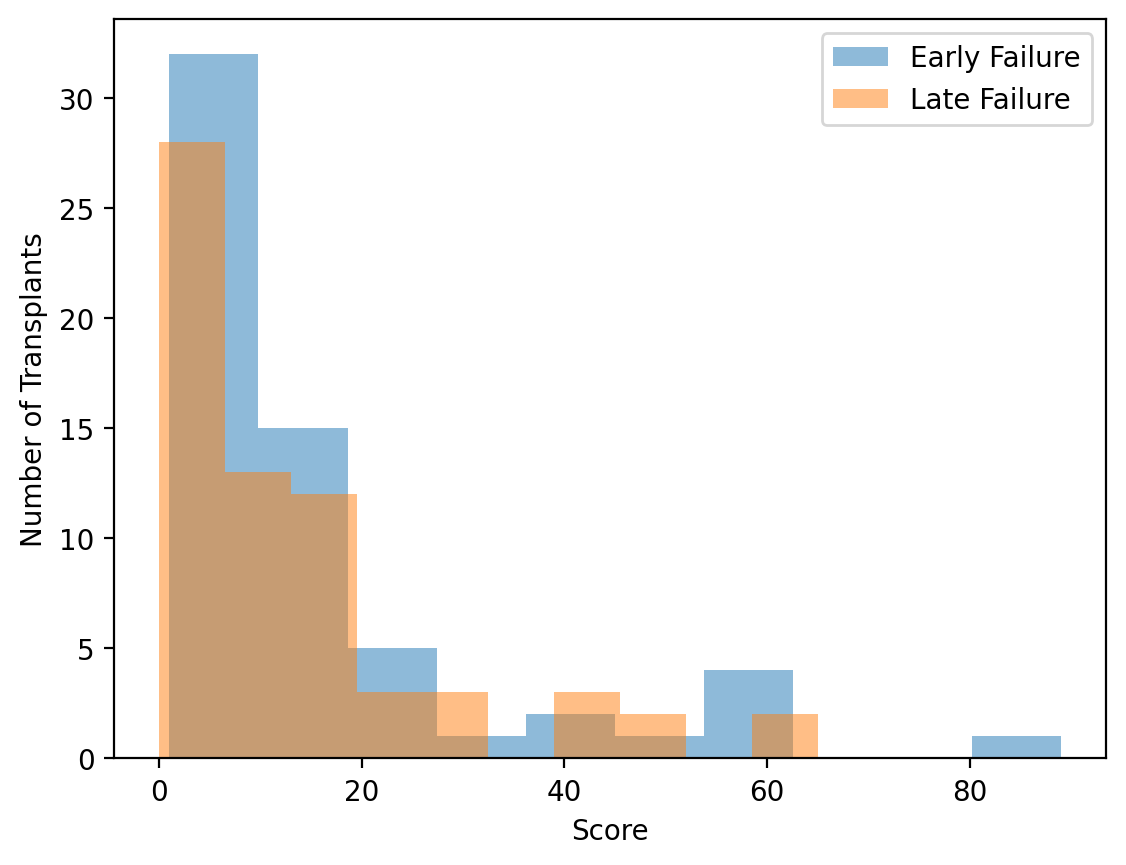

In [16]:
import matplotlib.pyplot as plt

df_dead_early['score'].plot.hist(alpha=0.5, label='Early Failure')
df_dead_late['score'].plot.hist(alpha=0.5, label='Late Failure')
plt.ylabel('Number of Transplants')
plt.xlabel('Score')
plt.legend();

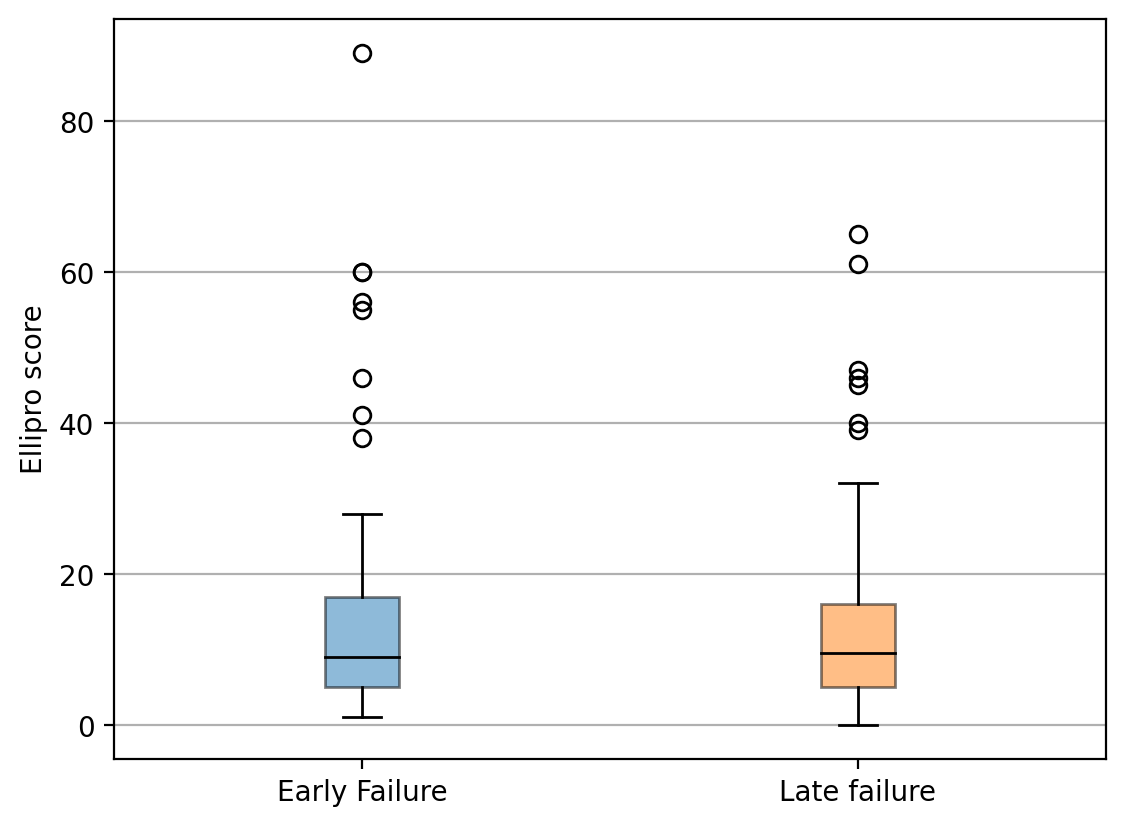

In [17]:
medianprops = dict(color='black')
fix, ax = plt.subplots()
bplot = ax.boxplot([df_dead_early['score'], df_dead_late['score']],
            labels = ['Early Failure', 'Late failure'],
            medianprops=medianprops,
            patch_artist=True)

colors = ['C0', 'C1']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(.5)

ax.set_ylabel('Ellipro score')
ax.yaxis.grid(True)
plt.savefig('boxplot.pdf', bbox_inches = 'tight')

Distributions are quite skewed, so let's do a nonparametric test:

In [18]:
scipy.stats.mannwhitneyu(df_dead_early['score'].values, df_dead_late['score'].values)

MannwhitneyuResult(statistic=2113.0, pvalue=0.630317577293616)

Alternatives would be Welch's t-test, or a trimmed mean t-test (because of the outlier in early failure)

In [19]:
scipy.stats.ttest_ind(df_dead_early['score'].values, df_dead_late['score'].values, equal_var=False) # Welch's t-test

Ttest_indResult(statistic=0.668207280330991, pvalue=0.5053340747825501)

In [20]:
scipy.stats.ttest_ind(df_dead_early['score'].values, df_dead_late['score'].values, trim = 0.2) # Yuen's t-test

Ttest_indResult(statistic=0.34024885769538743, pvalue=0.7346202710074443)

In [21]:
# df_dead_early['High'].plot.hist(alpha=0.5)
# df_dead_late['High'].plot.hist(alpha=0.5)

In [22]:
# df_dead_early['Intermediate'].plot.hist(alpha=0.5)
# df_dead_late['Intermediate'].plot.hist(alpha=0.5)

In [23]:
# df_dead_early['Low'].plot.hist(alpha=0.5)
# df_dead_late['Low'].plot.hist(alpha=0.5)

# Causal Analysis

In [24]:
# path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
# path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
# df_abs = pd.read_pickle(path_antibody)
# df_cohort = pd.read_pickle(path_cohort)
# df = df_abs.merge(df_cohort, on='TransplantID')
# print(df.columns)
# cols = [
#     'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
#     'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
#     'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', # 'FailureCode10y'
# ]
# df = df[cols]

# Cox PH Analysis with Continuous Treatment (Scores)

In [25]:
path = '~/Global Data/20210614-mismatch_ep_db-extended.pickle'
num_col = ['DonorAge_NOTR', 'DialysisYears', 'RecipientAge_NOTR', 'CIPHour_DBD', 'CIPHour_DCD']

df = (
    data_loading(path)
    .pipe(keeping_features,
        'TransplantID',
        'Failure',
        'Survival[Y]',
        'EpvsHLA_Donor',
        '#DESA',
        'DESA', 
        'DonorAge_NOTR',
        'DialysisYears',
        'RecipientAge_NOTR',
        'CIPHour_DBD', 
        'CIPHour_DCD' ,
        'Donor_Type',
        'IL2rMoAb_T0'
    )
    .pipe(integer_encoder, 'IL2rMoAb_T0')
    .pipe(polynomial_power2, 'DonorAge_NOTR', 'RecipientAge_NOTR')
    .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
    # .pipe(eng_immunological_features, antibody_epitope=True)
    .pipe(feature_scaler, num_col + ['DonorAge_NOTR_power2', 'RecipientAge_NOTR_power2'], scaler='maxmin')
    .pipe(censoring_deaths)
    # .pipe(setting_prediction_horizon, 15)
    .rename(columns={'IL2rMoAb_T0':'IL2rMoAb'})
)


In [26]:
# df_both = df_both[['TransplantID', 'period', 'score']].merge(df, on='TransplantID')
df

,TransplantID,EpvsHLA_Donor,#DESA,DESA,DonorAge_NOTR,DialysisYears,RecipientAge_NOTR,CIPHour_DBD,CIPHour_DCD,Donor_Type,IL2rMoAb,DonorAge_NOTR_power2,RecipientAge_NOTR_power2,E,T
0,4036,{},0,{},0.488889,0.076923,0.670886,0.168172,0.000000,Deceased,0,0.239012,0.455540,0,12.191781
1,2809,{},0,{},0.600000,0.070234,0.392405,0.406415,0.000000,Deceased,0,0.360000,0.159869,0,17.010959
2,862,{},0,{},0.488889,0.163880,0.329114,0.672688,0.000000,Deceased,0,0.239012,0.113768,1,6.956164
3,3549,{},0,{},0.255556,0.000000,0.493671,0.560573,0.000000,Deceased,1,0.065309,0.249883,1,4.509589
4,12,{},0,{},0.611111,0.180602,0.468354,0.000000,0.400388,Deceased,0,0.373457,0.225504,1,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4685,994,{},0,{},0.566667,0.050167,0.531646,0.541887,0.000000,Deceased,1,0.321111,0.288795,1,12.126027
4686,995,{},0,{},0.600000,0.056856,0.455696,0.386795,0.000000,Deceased,1,0.360000,0.213783,1,10.879452
4687,996,{},0,{},0.233333,0.117057,0.569620,0.321084,0.000000,Deceased,1,0.054444,0.330520,0,18.010959
4688,997,{},0,{},0.466667,0.083612,0.278481,0.000000,0.748450,Deceased,1,0.217778,0.082513,1,11.816438


In [27]:
# cols = ['TransplantID', 'Very Low', 'Low', 'Intermediate', 'High',	'score']
cols_final = ['TransplantID', 'RecipientAge_NOTR', 'DonorAge_NOTR', 'IL2rMoAb', 'CIPHour_DBD', 'CIPHour_DCD']

def cat_transformer(_df, df):

    return (
        _df[['TransplantID', 'period', 'score']]
        .merge(df, on='TransplantID')
        .assign(
            score_low = lambda x: x['score'].apply(lambda x: 1 if x <= 20 else 0),
            # score_medium = lambda x: x['score'].apply(lambda x: 1 if (x > 20 and x <= 40) else 0),
            score_high =  lambda x: x['score'].apply( lambda x: 1 if x > 20 else 0),
        )
    )

In [28]:
df_both = cat_transformer(df_both, df)

In [29]:
df_both

,TransplantID,period,score,EpvsHLA_Donor,#DESA,DESA,DonorAge_NOTR,DialysisYears,RecipientAge_NOTR,CIPHour_DBD,CIPHour_DCD,Donor_Type,IL2rMoAb,DonorAge_NOTR_power2,RecipientAge_NOTR_power2,E,T,score_low,score_high
0,327,early,11,"{'62GE': 'B*57:01', '62GRN': 'B*57:01', '74Y':...",7,"{94I, 71SA, 74Y, 97V, 62GE, 44RMA, 62GRN}",0.388889,0.123746,0.493671,0.000000,0.534884,Deceased,0,0.151235,0.249883,1,0.287671,1,0
1,279,early,60,"{'13SE': 'DRB3*03:01', '181T': 'DRB3*03:01', '...",25,"{98Q, 13SE, 4R, 70DA, 70Q, 98KS, 28D, 140TV, 4...",0.255556,0.264214,0.354430,0.409218,0.000000,Deceased,1,0.065309,0.131271,1,0.000000,0,1
2,678,early,60,"{'185I': 'DQB1*04:02', '55R': 'DQB1*04:02', '4...",21,"{46VY, 9F[DQ], 57S, 185I, 70DA, 55R, 74L, 77T[...",0.611111,0.033445,0.746835,0.000000,0.406977,Deceased,0,0.373457,0.562432,1,0.087671,0,1
3,1382,early,9,"{'45EV': 'DQB1*03:01', '55PPD': 'DQB1*03:01', ...",3,"{55PPD, 55PP, 45EV}",0.577778,0.053512,0.582278,0.000000,0.414729,Deceased,0,0.333827,0.345054,1,0.005479,1,0
4,5968,early,20,"{'37S': 'DRB1*16:01', '142M': 'DRB1*16:01', '9...",8,"{37S, 30G[DR], 71A, 6C, 96EV, 28H, 142M, 108T}",0.177778,0.100334,0.784810,0.000000,0.567054,Deceased,1,0.031605,0.620097,1,0.065753,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,632,late,6,"{'76ESI': 'A*25:01', '80I': 'A*25:01'}",2,"{80I, 76ESI}",0.588889,0.458194,0.797468,0.392401,0.000000,Deceased,1,0.346790,0.639944,0,18.010959,1,0
123,687,late,7,"{'151AHA': 'A*11:01', '163RW': 'A*11:01', '71Q...",3,"{163RW, 71QS, 151AHA}",0.566667,0.214047,0.443038,0.305201,0.000000,Deceased,1,0.321111,0.202375,0,12.008219,1,0
124,81,late,16,"{'56R': 'A*30:01', '152W': 'A*30:01', '17S': '...",7,"{17S, 56R, 79GT, 71QS, 76VDT, 97I, 152W}",0.400000,0.327759,0.506329,0.635316,0.000000,Deceased,1,0.160000,0.262541,1,15.860274,1,0
125,833,late,6,"{'57DE': 'DRB1*11:01', '51R': 'DRB3*02:02'}",2,"{51R, 57DE}",0.100000,0.090301,0.430380,0.421508,0.000000,Deceased,1,0.010000,0.191280,0,14.810959,1,0


In [30]:
confounders = [
    'RecipientAge_NOTR', 
    'RecipientAge_NOTR_power2',
    'DonorAge_NOTR',
    'DonorAge_NOTR_power2',
    # 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
    'DialysisYears',
    # 'score', 
    # 'score_low', 
    # 'score_medium', 
    'score_high',
]

In [31]:
from lifelines import CoxPHFitter
formula = ' + '.join(confounders)
df_both = df_both.pipe(feature_scaler, ['score'], scaler='maxmin')

df_l = df_both[df_both.period.eq('early')]
cph = CoxPHFitter()
cph.fit(df_l, duration_col='T', event_col='E', formula=formula)
cph.print_summary()

/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/lifelines/fitters/__init__.py:1268: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) >= "1.1.0":
/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<lifelines.CoxPHFitter: fitted with 61 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 61
number of events observed = 61
   partial log-likelihood = -189.13
         time fit was run = 2023-07-20 15:24:26 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
CIPHour_DBD               -1.54       0.21       1.12            -3.73             0.65                 0.02                 1.91
CIPHour_DCD               -1.30       0.27       1.07            -3.39             0.79                 0.03                 2.21
DialysisYears             -2.90       0.06       1.84            -6.50             0.70                 0.00                 2.02
DonorAge_NOTR             -5.17       0.01       3.07           -11.18             0.85                 0.00                 2.34
DonorAge_NOTR_power2       5.66     287.75       3.70            -1.59            12.92                 0.20             4.08e+05
RecipientAge_NOTR          2.61      13.65       4.46            -6.13            11.36                 0.00             85835.90
RecipientAge_NOTR_power2  -2.40       0.09       4.19           -10.61             5.82                 0.00               336.09
score_high                -0.17       0.84       0.37            -0.89             0.55                 0.41                 1.72

                             z    p   -log2(p)
covariate                                     
CIPHour_DBD              -1.38 0.17       2.58
CIPHour_DCD              -1.22 0.22       2.16
DialysisYears            -1.58 0.11       3.12
DonorAge_NOTR            -1.68 0.09       3.44
DonorAge_NOTR_power2      1.53 0.13       2.99
RecipientAge_NOTR         0.59 0.56       0.84
RecipientAge_NOTR_power2 -0.57 0.57       0.82
score_high               -0.47 0.64       0.65
---
Concordance = 0.60
Partial AIC = 394.27
log-likelihood ratio test = 7.21 on 8 df
-log2(p) of ll-ratio test = 0.96

In [32]:
cph.check_assumptions(df_both[df_both.period.eq('early')], p_value_threshold=0.05, show_plots=True)

/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


Proportional hazard assumption looks okay.


[]

In [33]:
from lifelines import CoxPHFitter
formula = ' + '.join(confounders)
df_both = df_both.pipe(feature_scaler, ['score'], scaler='maxmin')

df_l = df_both[df_both.period.eq('late')]
cph = CoxPHFitter()
cph.fit(df_l, duration_col='T', event_col='E', formula=formula)
cph.print_summary()

/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/lifelines/fitters/__init__.py:1268: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) >= "1.1.0":
/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<lifelines.CoxPHFitter: fitted with 66 total observations, 54 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 66
number of events observed = 12
   partial log-likelihood = -30.77
         time fit was run = 2023-07-20 15:24:27 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
CIPHour_DBD               -4.53       0.01       3.11           -10.63             1.57                 0.00                 4.83
CIPHour_DCD               -1.72       0.18       3.07            -7.74             4.30                 0.00                73.82
DialysisYears             -1.29       0.28       3.18            -7.52             4.94                 0.00               139.36
DonorAge_NOTR             23.32   1.35e+10      17.08           -10.16            56.80                 0.00             4.68e+24
DonorAge_NOTR_power2     -34.09       0.00      23.95           -81.03            12.86                 0.00             3.83e+05
RecipientAge_NOTR        -10.95       0.00       8.35           -27.31             5.41                 0.00               223.44
RecipientAge_NOTR_power2  11.92   1.50e+05       8.34            -4.42            28.26                 0.01             1.88e+12
score_high                -1.09       0.33       1.17            -3.39             1.20                 0.03                 3.32

                             z    p   -log2(p)
covariate                                     
CIPHour_DBD              -1.45 0.15       2.78
CIPHour_DCD              -0.56 0.58       0.80
DialysisYears            -0.41 0.68       0.55
DonorAge_NOTR             1.37 0.17       2.54
DonorAge_NOTR_power2     -1.42 0.15       2.69
RecipientAge_NOTR        -1.31 0.19       2.40
RecipientAge_NOTR_power2  1.43 0.15       2.71
score_high               -0.93 0.35       1.51
---
Concordance = 0.74
Partial AIC = 77.54
log-likelihood ratio test = 11.59 on 8 df
-log2(p) of ll-ratio test = 2.55

In [34]:
cph.check_assumptions(df_both[df_both.period.eq('late')], p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

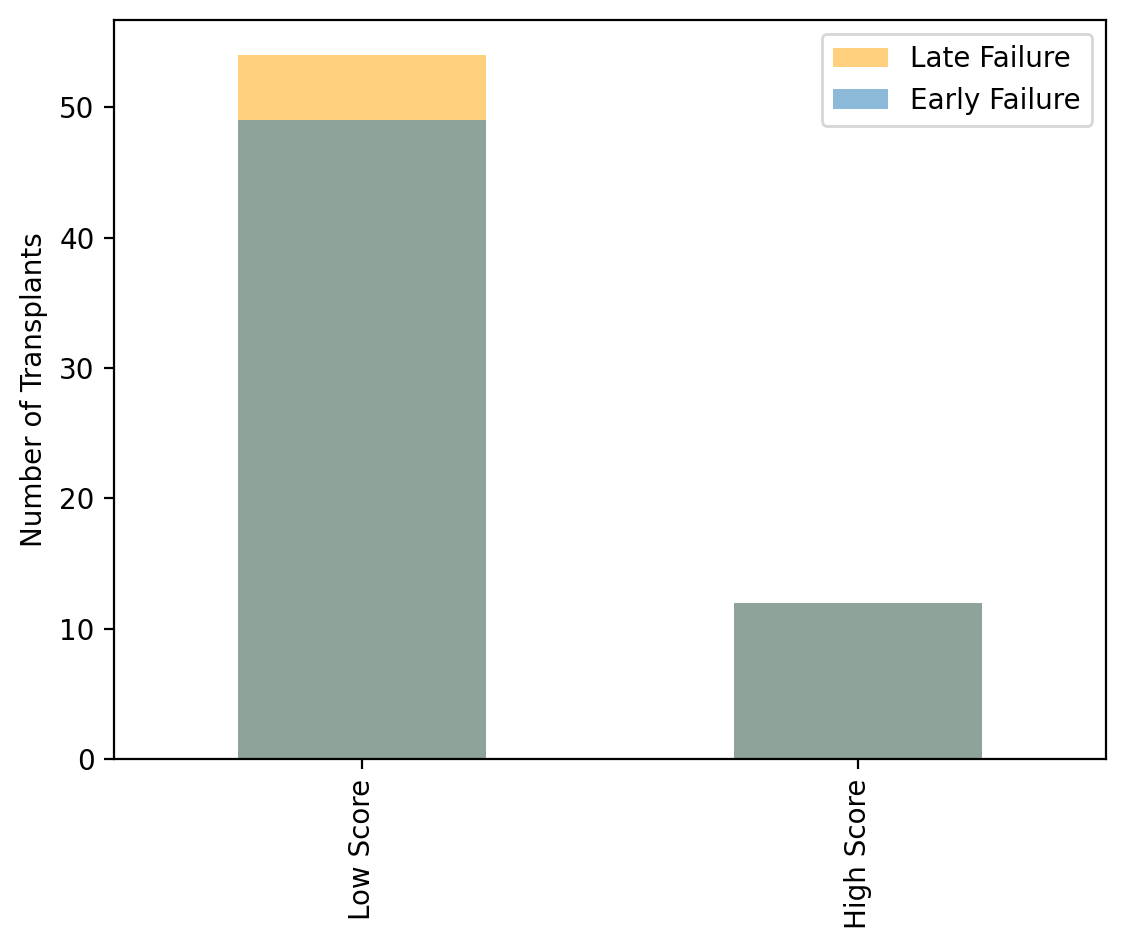

In [35]:
df_both[df_both.period.eq('late')]['score_high'].value_counts().plot.bar(alpha=0.5, color='orange', label='Late Failure')
df_both[df_both.period.eq('early')]['score_high'].value_counts().plot.bar(alpha=0.5, label='Early Failure')
plt.xticks([0, 1], ['Low Score', 'High Score'])
plt.ylabel('Number of Transplants')
plt.legend()

In [36]:
# df_both[df_both.period.eq('late')]['score_medium'].plot.hist(alpha=0.5)
# df_both[df_both.period.eq('early')]['score_medium'].plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

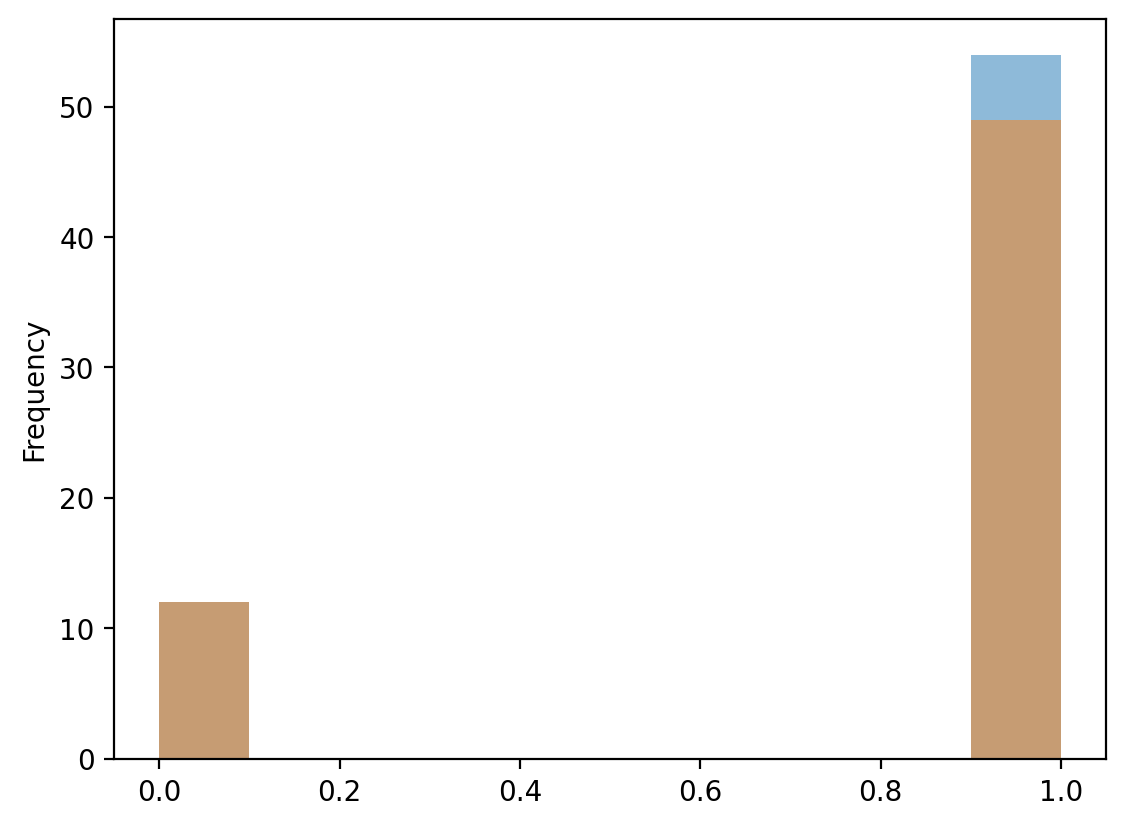

In [37]:
df_both[df_both.period.eq('late')]['score_low'].plot.hist(alpha=0.5)
df_both[df_both.period.eq('early')]['score_low'].plot.hist(alpha=0.5)

# Kaplan Meier Curves

<AxesSubplot:xlabel='timeline'>

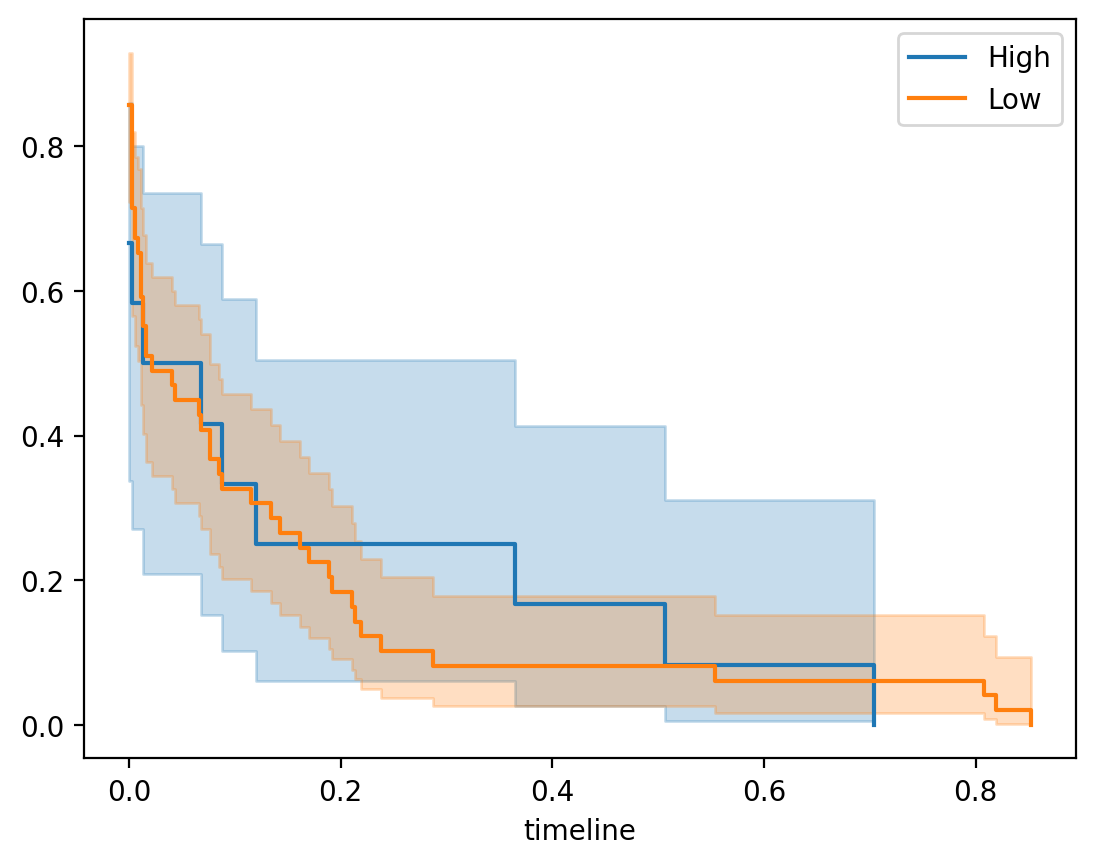

In [38]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from matplotlib.offsetbox import AnchoredText

kmf = KaplanMeierFitter()

ax = plt.subplot(111)

ind_period = df_both['period'].eq('early')
ind_high = df_both['score_high'].eq(1)

kmf.fit(df_both[ind_period & ind_high]['T'], event_observed=df_both[ind_period & ind_high]['E'], label="High")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_both[ind_period & ~ind_high]['T'], event_observed=df_both[ind_period & ~ind_high]['E'], label="Low")
kmf.plot_survival_function(ax=ax)


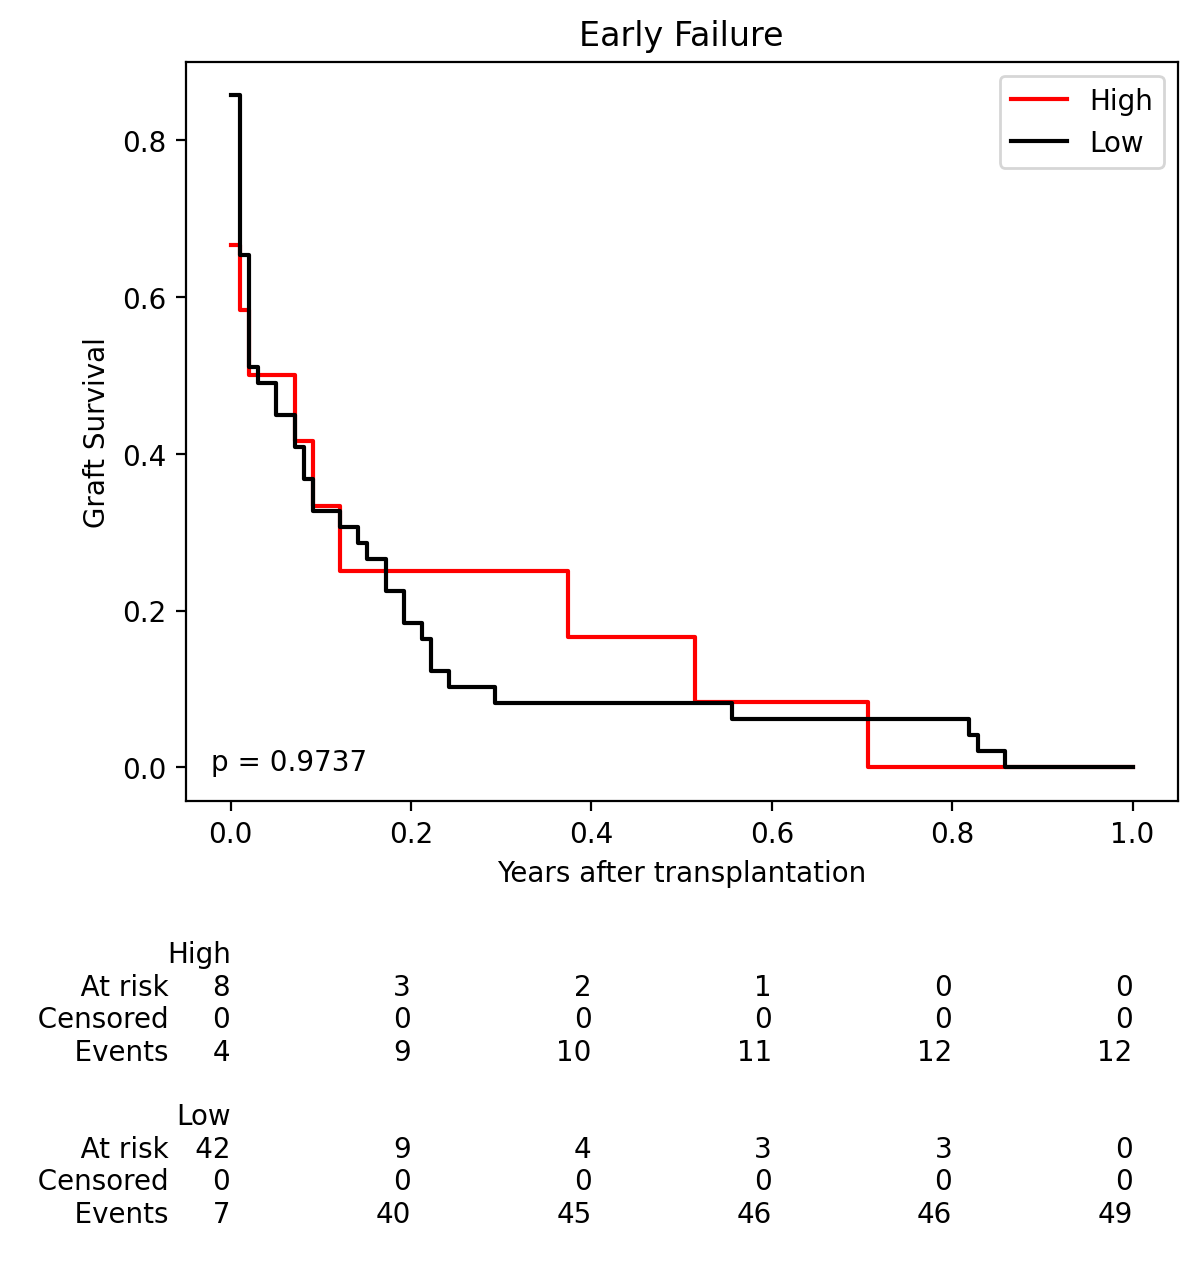

In [39]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
ax = plt.subplot(111)

t = np.linspace(0, 1, 100)

ind_period = df_both['period'].eq('early')
ind_high = df_both['score_high'].eq(1)
ind_1 = ind_period & ind_high
ind_2 = ind_period & ~ind_high

kmf1.fit(df_both[ind_1]['T'], event_observed=df_both[ind_1]['E'], timeline=t, label="High")
kmf1.plot_survival_function(ax=ax, ci_show = False, color = 'red')

kmf2.fit(df_both[ind_2]['T'], event_observed=df_both[ind_2]['E'],  timeline=t, label="Low")
kmf2.plot_survival_function(ax=ax, ci_show = False, color = 'black')


add_at_risk_counts(kmf1, kmf2, ax=ax, fontsize=10, rows_to_show=["At risk", "Censored", "Events"])


# Calculate statistical significance
from lifelines.statistics import logrank_test
log_rank_test_result = logrank_test(df_both[ind_1]['T'], df_both[ind_2]['T'], event_observed_A=df_both[ind_1]['E'], event_observed_B=df_both[ind_2]['E'])
p_value = log_rank_test_result.p_value

p_value_string = 'p < 0.0001' if p_value < 0.0001 else f'p = {p_value:.4f}'
ax.add_artist(AnchoredText(p_value_string, loc=3, frameon=False))

#ax.yaxis.grid() # horizontal lines
#ax.xaxis.grid()
ax.set_xlabel("Years after transplantation");
ax.set_ylabel("Graft Survival");
plt.title('Early Failure')
#plt.show();
plt.savefig('early-failure.pdf', bbox_inches = 'tight')

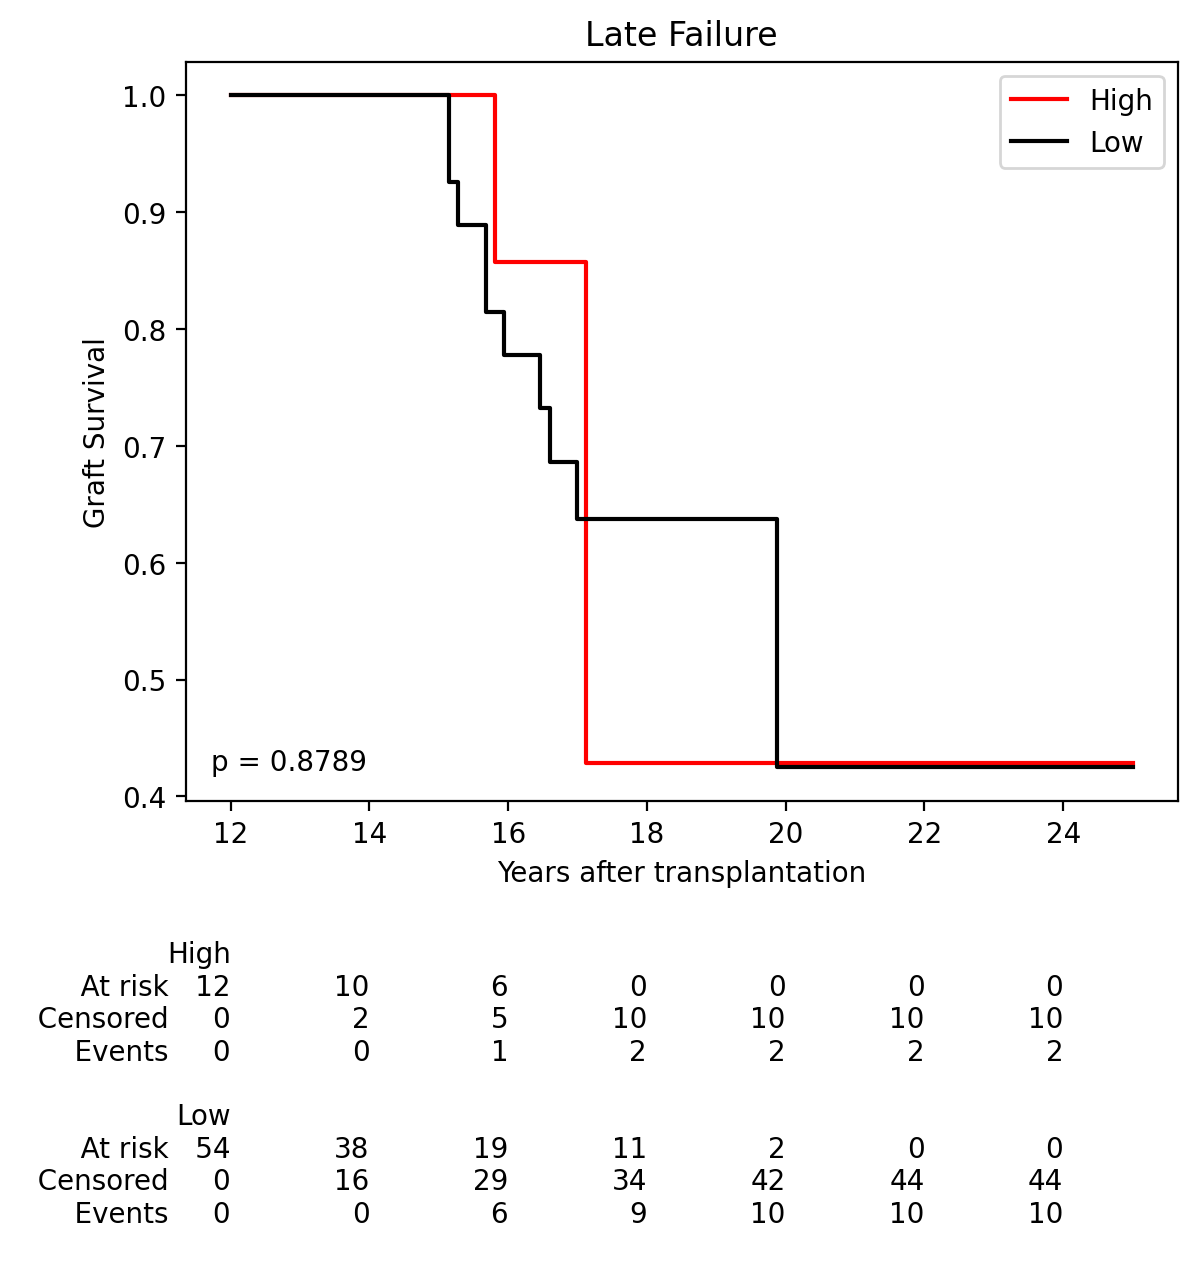

In [40]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
ax = plt.subplot(111)

t = np.linspace(12, 25, 100)

ind_period = df_both['period'].eq('late')
ind_high = df_both['score_high'].eq(1)
ind_1 = ind_period & ind_high
ind_2 = ind_period & ~ind_high

kmf1.fit(df_both[ind_1]['T'], event_observed=df_both[ind_1]['E'], timeline=t, label="High")
kmf1.plot_survival_function(ax=ax, ci_show = False, color = 'red')

kmf2.fit(df_both[ind_2]['T'], event_observed=df_both[ind_2]['E'],  timeline=t, label="Low")
kmf2.plot_survival_function(ax=ax, ci_show = False, color = 'black')


add_at_risk_counts(kmf1, kmf2, ax=ax, fontsize=10, rows_to_show=["At risk", "Censored", "Events"])


# Calculate statistical significance
from lifelines.statistics import logrank_test
log_rank_test_result = logrank_test(df_both[ind_1]['T'], df_both[ind_2]['T'], event_observed_A=df_both[ind_1]['E'], event_observed_B=df_both[ind_2]['E'])
p_value = log_rank_test_result.p_value

p_value_string = 'p < 0.0001' if p_value < 0.0001 else f'p = {p_value:.4f}'
ax.add_artist(AnchoredText(p_value_string, loc=3, frameon=False))

#ax.yaxis.grid() # horizontal lines
#ax.xaxis.grid()
ax.set_xlabel("Years after transplantation");
ax.set_ylabel("Graft Survival");
plt.title('Late Failure')
#plt.show();
plt.savefig('late-failure.pdf', bbox_inches = 'tight')